# Timetree Analysis

1. Plot root-to-tip regression with date (tips).
1. Estimate a time-scaled phylogeny.
1. Plot root-to-tip regression with date (tips+internals)
1. Plot timetree.


**TO-DO**:

1. Identify if the local branch_length change is significant:

```python
# Line 403 of the treeanc.py file
# self.tree.root.branch_length = 0.001
self.tree.root.branch_length = self.tree.root.branch_length
```

1. Refine timetree parameters, specifically:
   - Relaxed clock
   - Marginal date estimation and confidence

In [1]:
import treetime
import matplotlib.pyplot as plt
from matplotlib import patches
from Bio import Phylo
import os
import numpy as np
import pandas as pd
import random
import math

pd.set_option("display.max_rows", None, "display.max_columns", None)
random.seed(1152342, 2)

tree_path = "../../docs/results/latest/branch_support/branch_support.nwk"
#metadata_path = "../../docs/results/latest/metadata/metadata.tsv"
metadata_path = "../../docs/results/latest/mugration/mugration.tsv"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
outdir = "../../docs/results/latest/timetree/"

# Font
SM_FONT = 5
MED_FONT = 8
LG_FONT = 10

plt.rc('font', size=SM_FONT)          # controls default text sizes
plt.rc('figure', titlesize=LG_FONT)  # fontsize of the figure title
plt.rc('axes', labelsize=MED_FONT)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
dpi = 400

NO_DATA_CHAR = "NA"
DATE_COL = "Date"
#NAME_COL = "Sample"
NAME_COL = "Name"
REF_DATE = 1992.0
REF_LEN = 4653728
CONFIDENCE=0.95
N_IQD=3

COLOR_PAL = "tab10"
CMAP_N = 10
cmap = plt.get_cmap(COLOR_PAL, CMAP_N)
cmaplist = [cmap(i) for i in range(cmap.N)]

MUG_ATTR = "Branch_Major"

### Create a basic TimeTree Object


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.

0.00	-TreeAnc: set-up

0.04	-###TEST.TreeAnc.prepare_tree: BEGIN

1.11	-SequenceData: loaded alignment.
1.11	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.11	-SeqData: making compressed alignment...

3.66	-SequenceData: constructed compressed alignment...
3.87	--ClockTree: Setting precision to level 2

3.94	-ClockTree._assign_dates: assigned date contraints to 523 out of 523 tips.
4.21	--ClockTree.date2dist: Setting new molecular clock. rate=9.668e-09,
    	  R^2=0.2481

4.23	-###TEST.TreeAnc.prepare_tree: BEGIN


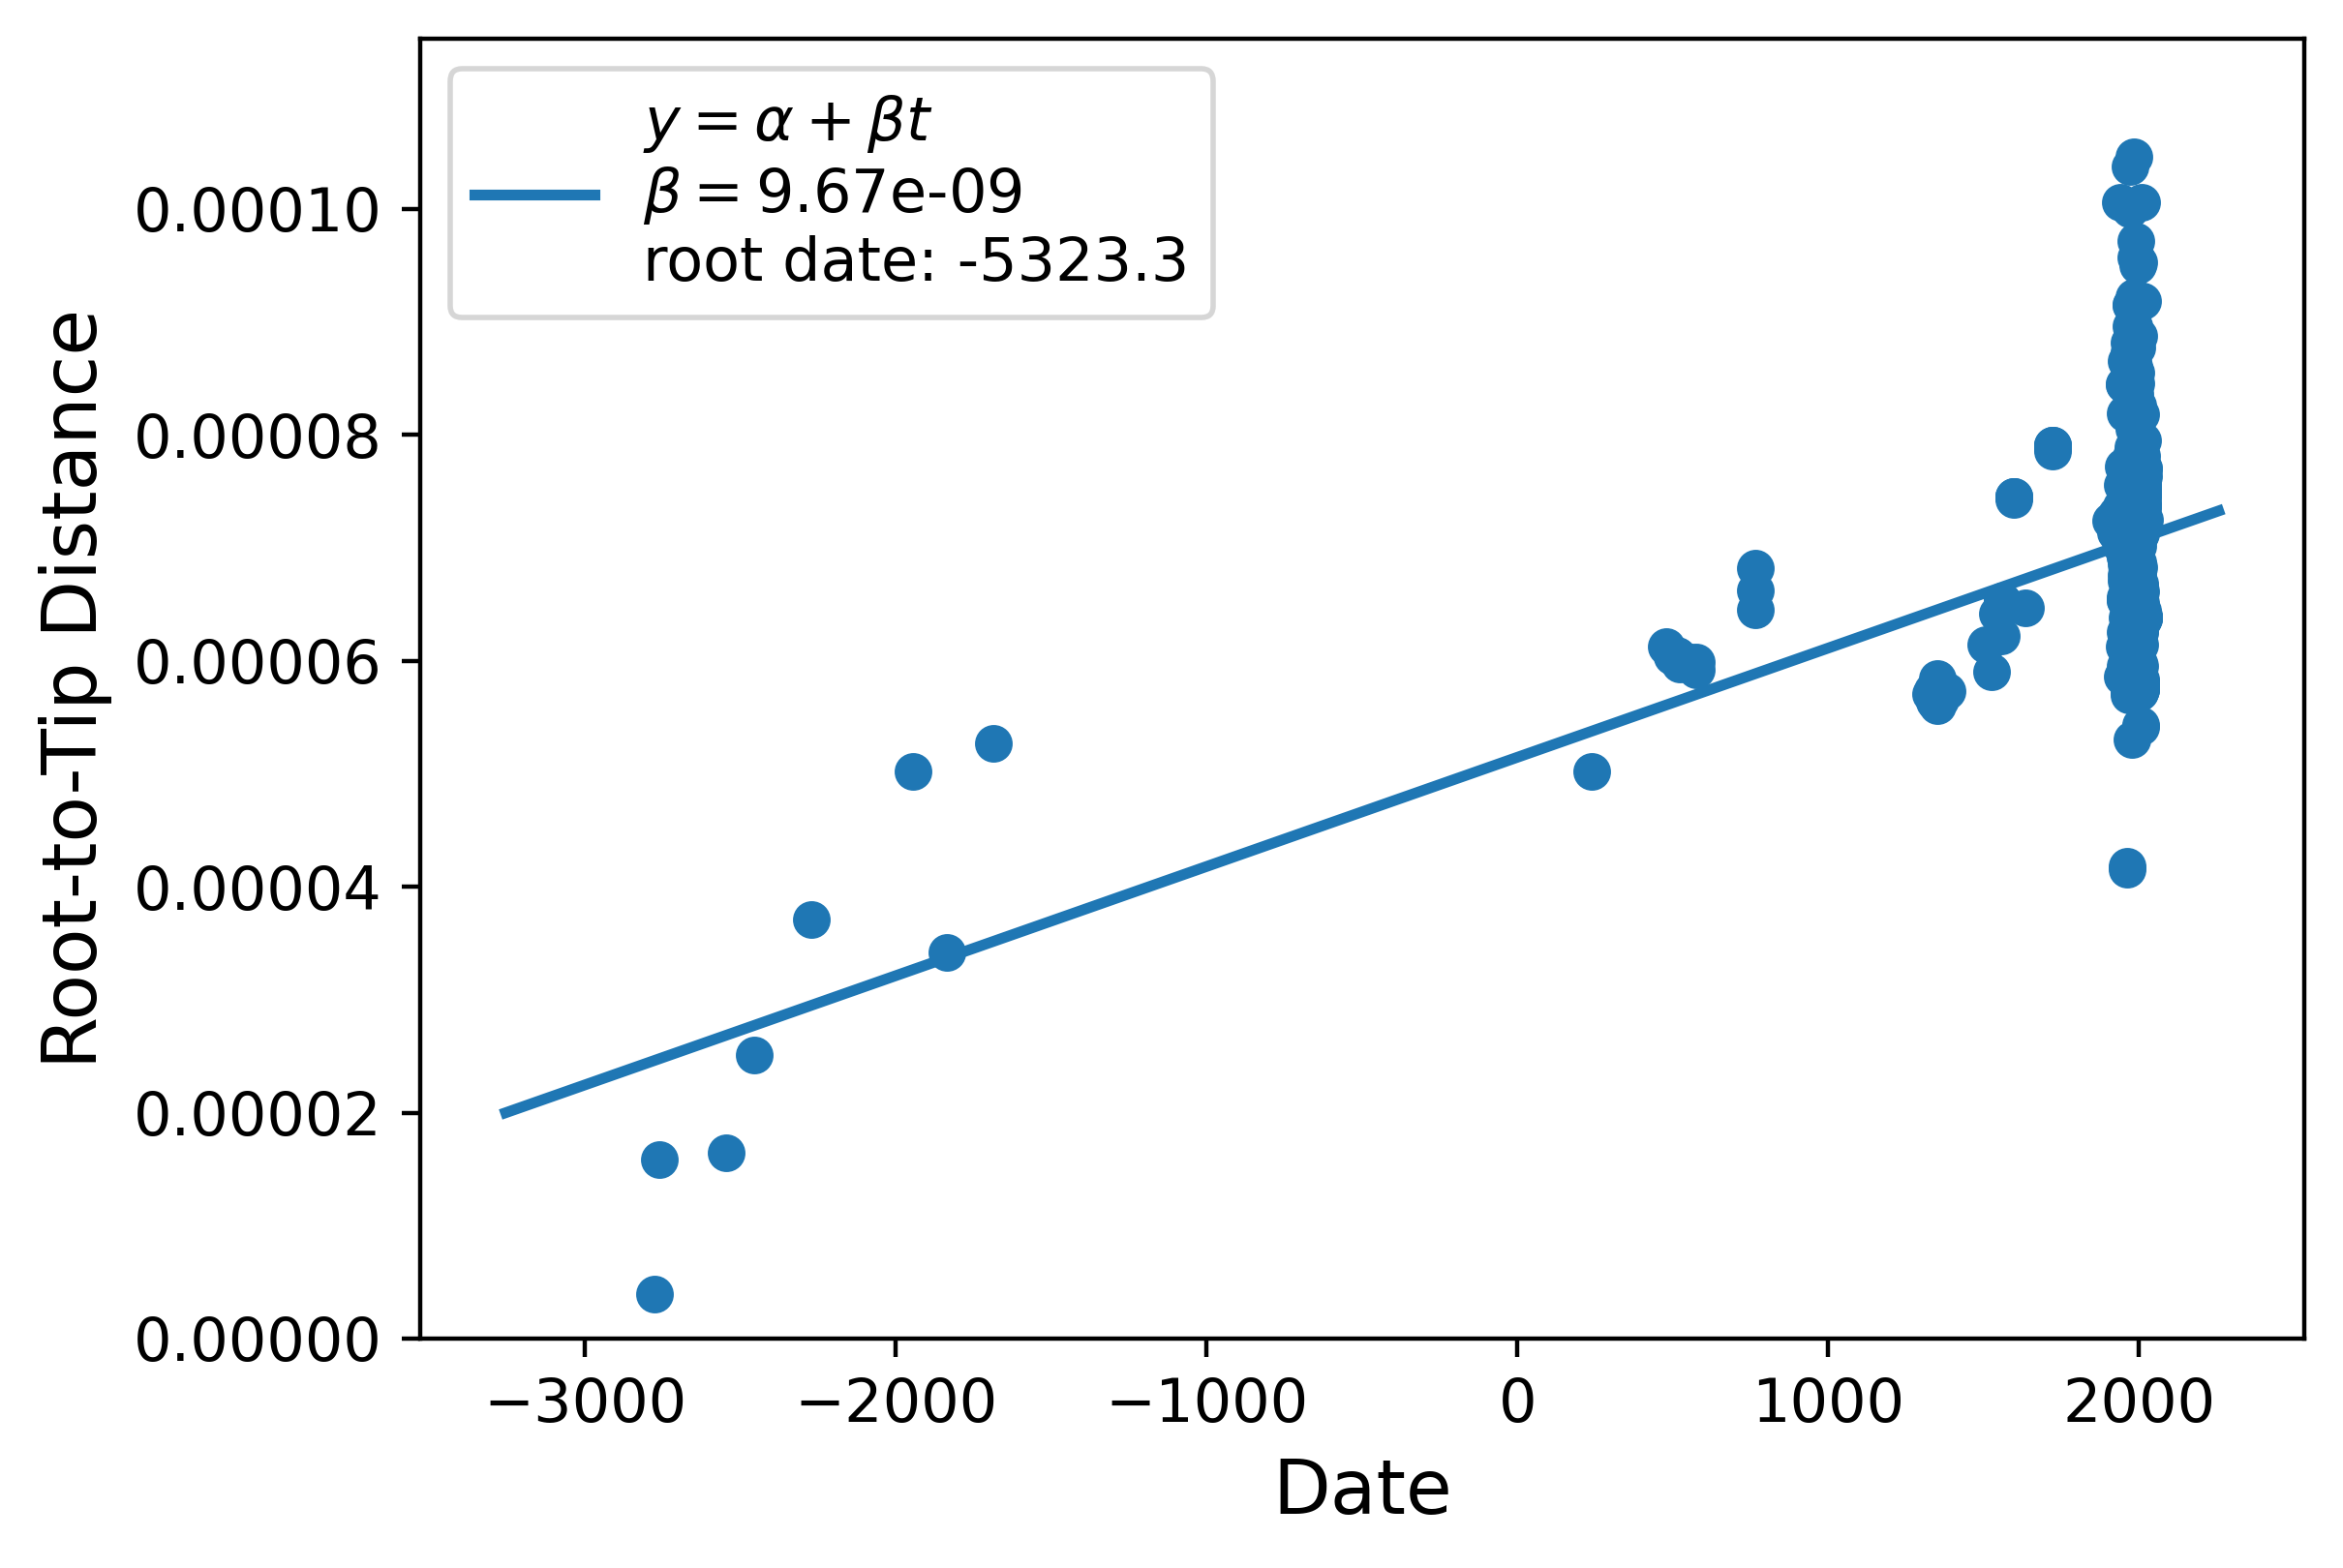

In [2]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(metadata_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v

# Add the reference date
dates["Reference"] = REF_DATE

# Construct the treetime object
tt = treetime.TreeTime(dates=dates, 
                       aln=aln_path,
                       tree=tree_path, 
                       seq_len=REF_LEN,
                       verbose=4, 
                       fill_overhangs=False,)

# Remove outliers
tt.clock_filter(reroot=None, 
                n_iqd=N_IQD, 
                plot=False,
               )

# Plot the root to tip regression
fig, (ax1) = plt.subplots(1, dpi=400)
tt.plot_root_to_tip(
    ax=ax1,
    )
#ax1.get_lines()[0].set_color("#1f77b4")
#ax1.get_lines()[0].set_color("#ff7f0e")
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")

# Save the figure
out_path = os.path.join(outdir, "timetree_rtt_pre.jpg") 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

In [3]:
# Run time tree analysis
# Do I need the local modification of setting the root branch length to 0?

# PARAM SET 1: date='-4262-12-02'
tt.run()

# PARAM SET 3
# Resolve polytomies might be problematic, nodes are being deleted and recreated.
# This may affect my node dataframe
#tt.run(root=None, infer_gtr=True, relaxed_clock=False, max_iter=1,
#                    branch_length_mode='input', n_iqd=3, resolve_polytomies=False,
#                    Tc='skyline', time_marginal="assign", vary_rate=True)

# PARAM SET 3
# Remove time_marginal?


6.06	-TreeTime._set_branch_length_mode: maximum branch length is 3.648e-05,
    	 using branch length mode joint

6.06	-TreeAnc.optimize_tree: sequences...

6.06	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

6.06	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
6.06	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
6.06	---TreeAnc._ml_anc_joint: Walking up the tree, computing likelihoods...
10.42	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
     	   likelihood sequences...
10.59	---TreeAnc._ml_anc_joint: ...done
10.60	--TreeAnc.infer_gtr: counting mutations...
11.77	---TreeAnc.infer_gtr: counting mutations...done

11.78	-G


103.63	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_009670575.1_ASM967057v1_genomic years_bp38.04794520547944

103.63	-TEST.ClockTree.convert_dates -- numdate: 1983.0

103.63	-TEST.ClockTree.convert_dates -- date: 1983-01-01

103.63	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_009670625.1_ASM967062v1_genomic years_bp38.04794520547944

103.63	-TEST.ClockTree.convert_dates -- numdate: 1983.0

103.63	-TEST.ClockTree.convert_dates -- date: 1983-01-01

103.63	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_009670355.1_ASM967035v1_genomic years_bp35.04794520547944

103.63	-TEST.ClockTree.convert_dates -- numdate: 1986.0

103.63	-TEST.ClockTree.convert_dates -- date: 1986-01-01

103.63	-TEST.ClockTree.convert_dates -- node name: NODE748
      	 years_bp49.04783143847258

103.63	-TEST.ClockTree.convert_dates -- numdate: 1972.000113767007

103.64	-TEST.ClockTree.convert_dates -- date: 1972-01-01

103.64	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_00967


103.84	-TEST.ClockTree.convert_dates -- numdate: 1947.4002392882378

103.84	-TEST.ClockTree.convert_dates -- date: 1947-05-27

103.84	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000323645.1_ASM32364v1_genomic years_bp34.04794520547944

103.84	-TEST.ClockTree.convert_dates -- numdate: 1987.0

103.84	-TEST.ClockTree.convert_dates -- date: 1987-01-01

103.84	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000324985.1_ASM32498v1_genomic years_bp34.04794520547944

103.84	-TEST.ClockTree.convert_dates -- numdate: 1987.0

103.84	-TEST.ClockTree.convert_dates -- date: 1987-01-01

103.85	-TEST.ClockTree.convert_dates -- node name: NODE482
      	 years_bp70.76097218543357

103.85	-TEST.ClockTree.convert_dates -- numdate: 1950.286973020046

103.85	-TEST.ClockTree.convert_dates -- date: 1950-04-15

103.85	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000169655.1_ASM16965v1_genomic years_bp48.04794520547944

103.85	-TEST.ClockTree.convert_dates -- numdate: 1973.0

10


104.05	-TEST.ClockTree.convert_dates -- node name: SAMEA3713711
      	 years_bp299.0478314384726

104.05	-TEST.ClockTree.convert_dates -- numdate: 1722.000113767007

104.05	-TEST.ClockTree.convert_dates -- date: 1722-01-01

104.05	-TEST.ClockTree.convert_dates -- node name: SAMEA3713714
      	 years_bp301.0478314384726

104.05	-TEST.ClockTree.convert_dates -- numdate: 1720.000113767007

104.05	-TEST.ClockTree.convert_dates -- date: 1720-01-01

104.05	-TEST.ClockTree.convert_dates -- node name: SAMEA3713712
      	 years_bp299.0478314384726

104.05	-TEST.ClockTree.convert_dates -- numdate: 1722.000113767007

104.05	-TEST.ClockTree.convert_dates -- date: 1722-01-01

104.05	-TEST.ClockTree.convert_dates -- node name: SAMEA3713713
      	 years_bp299.0478314384726

104.05	-TEST.ClockTree.convert_dates -- numdate: 1722.000113767007

104.05	-TEST.ClockTree.convert_dates -- date: 1722-01-01

104.05	-TEST.ClockTree.convert_dates -- node name: NODE330
      	 years_bp487.32608841639916

104.


104.28	-TEST.ClockTree.convert_dates -- numdate: 2008.0

104.28	-TEST.ClockTree.convert_dates -- date: 2008-01-01

104.28	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000269365.1_ASM26936v1_genomic years_bp11.047945205479436

104.28	-TEST.ClockTree.convert_dates -- numdate: 2010.0

104.28	-TEST.ClockTree.convert_dates -- date: 2010-01-01

104.28	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000269125.1_ASM26912v1_genomic years_bp11.047945205479436

104.28	-TEST.ClockTree.convert_dates -- numdate: 2010.0

104.28	-TEST.ClockTree.convert_dates -- date: 2010-01-01

104.28	-TEST.ClockTree.convert_dates -- node name: NODE55
      	 years_bp23.361701647206942

104.28	-TEST.ClockTree.convert_dates -- numdate: 1997.6862435582725

104.28	-TEST.ClockTree.convert_dates -- date: 1997-09-08

104.28	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000268945.1_ASM26894v1_genomic years_bp11.047945205479436

104.28	-TEST.ClockTree.convert_dates -- numdate: 2010.0

104.28	-TE

'success'

In [4]:
# Quick check
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch_length=0.0, clock_length=0.0, date='-4184-09-06', dist2root=0.0, mutation_length=0.0, name='NODE0', original_length=0.0)

### Add dates to dataframe

In [5]:
tree_df = pd.read_csv(metadata_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

# Create a new column for date
tree_df[DATE_COL + "_timetree"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
#tree_df[DATE_COL + "_timetree_conf"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
for c in tt.tree.find_clades():
    #print(dir(c))
    #print(c.name, c.date, c.numdate)
    tree_df.at[c.name, DATE_COL + "_timetree"] = c.numdate
    #conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
    #tree_df.at[c.name, DATE_COL + "_timetree_conf"] = conf
#tree_df[["Date", "Date_timetree", "Date_timetree_conf"]]
tree_df

,UFboot,aLRT,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Major_Color,Mugration_Branch_Minor_Color,Date_timetree
Name,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,100,0.000000e+00,red,0.000000,507.024237,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Bronze Age,0.998711,Bronze Age,0.999225,#8000ff,#8000ff,-4183.32
NODE1,100,99.9,5.224800e-06,red,0.000005,491.048473,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.PE,0.998601,0.PE7,0.394498,#5148fc,grey,-3790.06
NODE2,100,100,1.823010e-05,red,0.000023,466.596946,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.PE,0.999998,0.PE2,0.479131,#5148fc,grey,-2721.89
NODE3,100,100,1.067900e-05,red,0.000034,431.816451,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.PE,0.999998,0.PE5,0.216464,#5148fc,grey,-1763.24
NODE4,100,97.9,2.123000e-06,red,0.000036,398.239348,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.PE,0.998617,0.PE5,0.493901,#5148fc,grey,-1435.56
NODE5,100,100,9.676500e-06,red,0.000046,367.306821,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.ANT,0.995876,0.ANT1,0.479678,#238af5,grey,-206.728
NODE6,100,98.9,2.056700e-06,red,0.000048,318.500023,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.ANT,0.995862,First Pandemic,0.492381,#238af5,grey,-57.0637
NODE7,100,100,5.688000e-06,red,0.000054,303.492233,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.ANT,0.999985,0.ANT3,0.218411,#238af5,grey,678.644
NODE8,100,98.4,1.172000e-06,red,0.000055,286.984467,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.ANT,0.999386,0.ANT3,0.508991,#238af5,grey,783.939


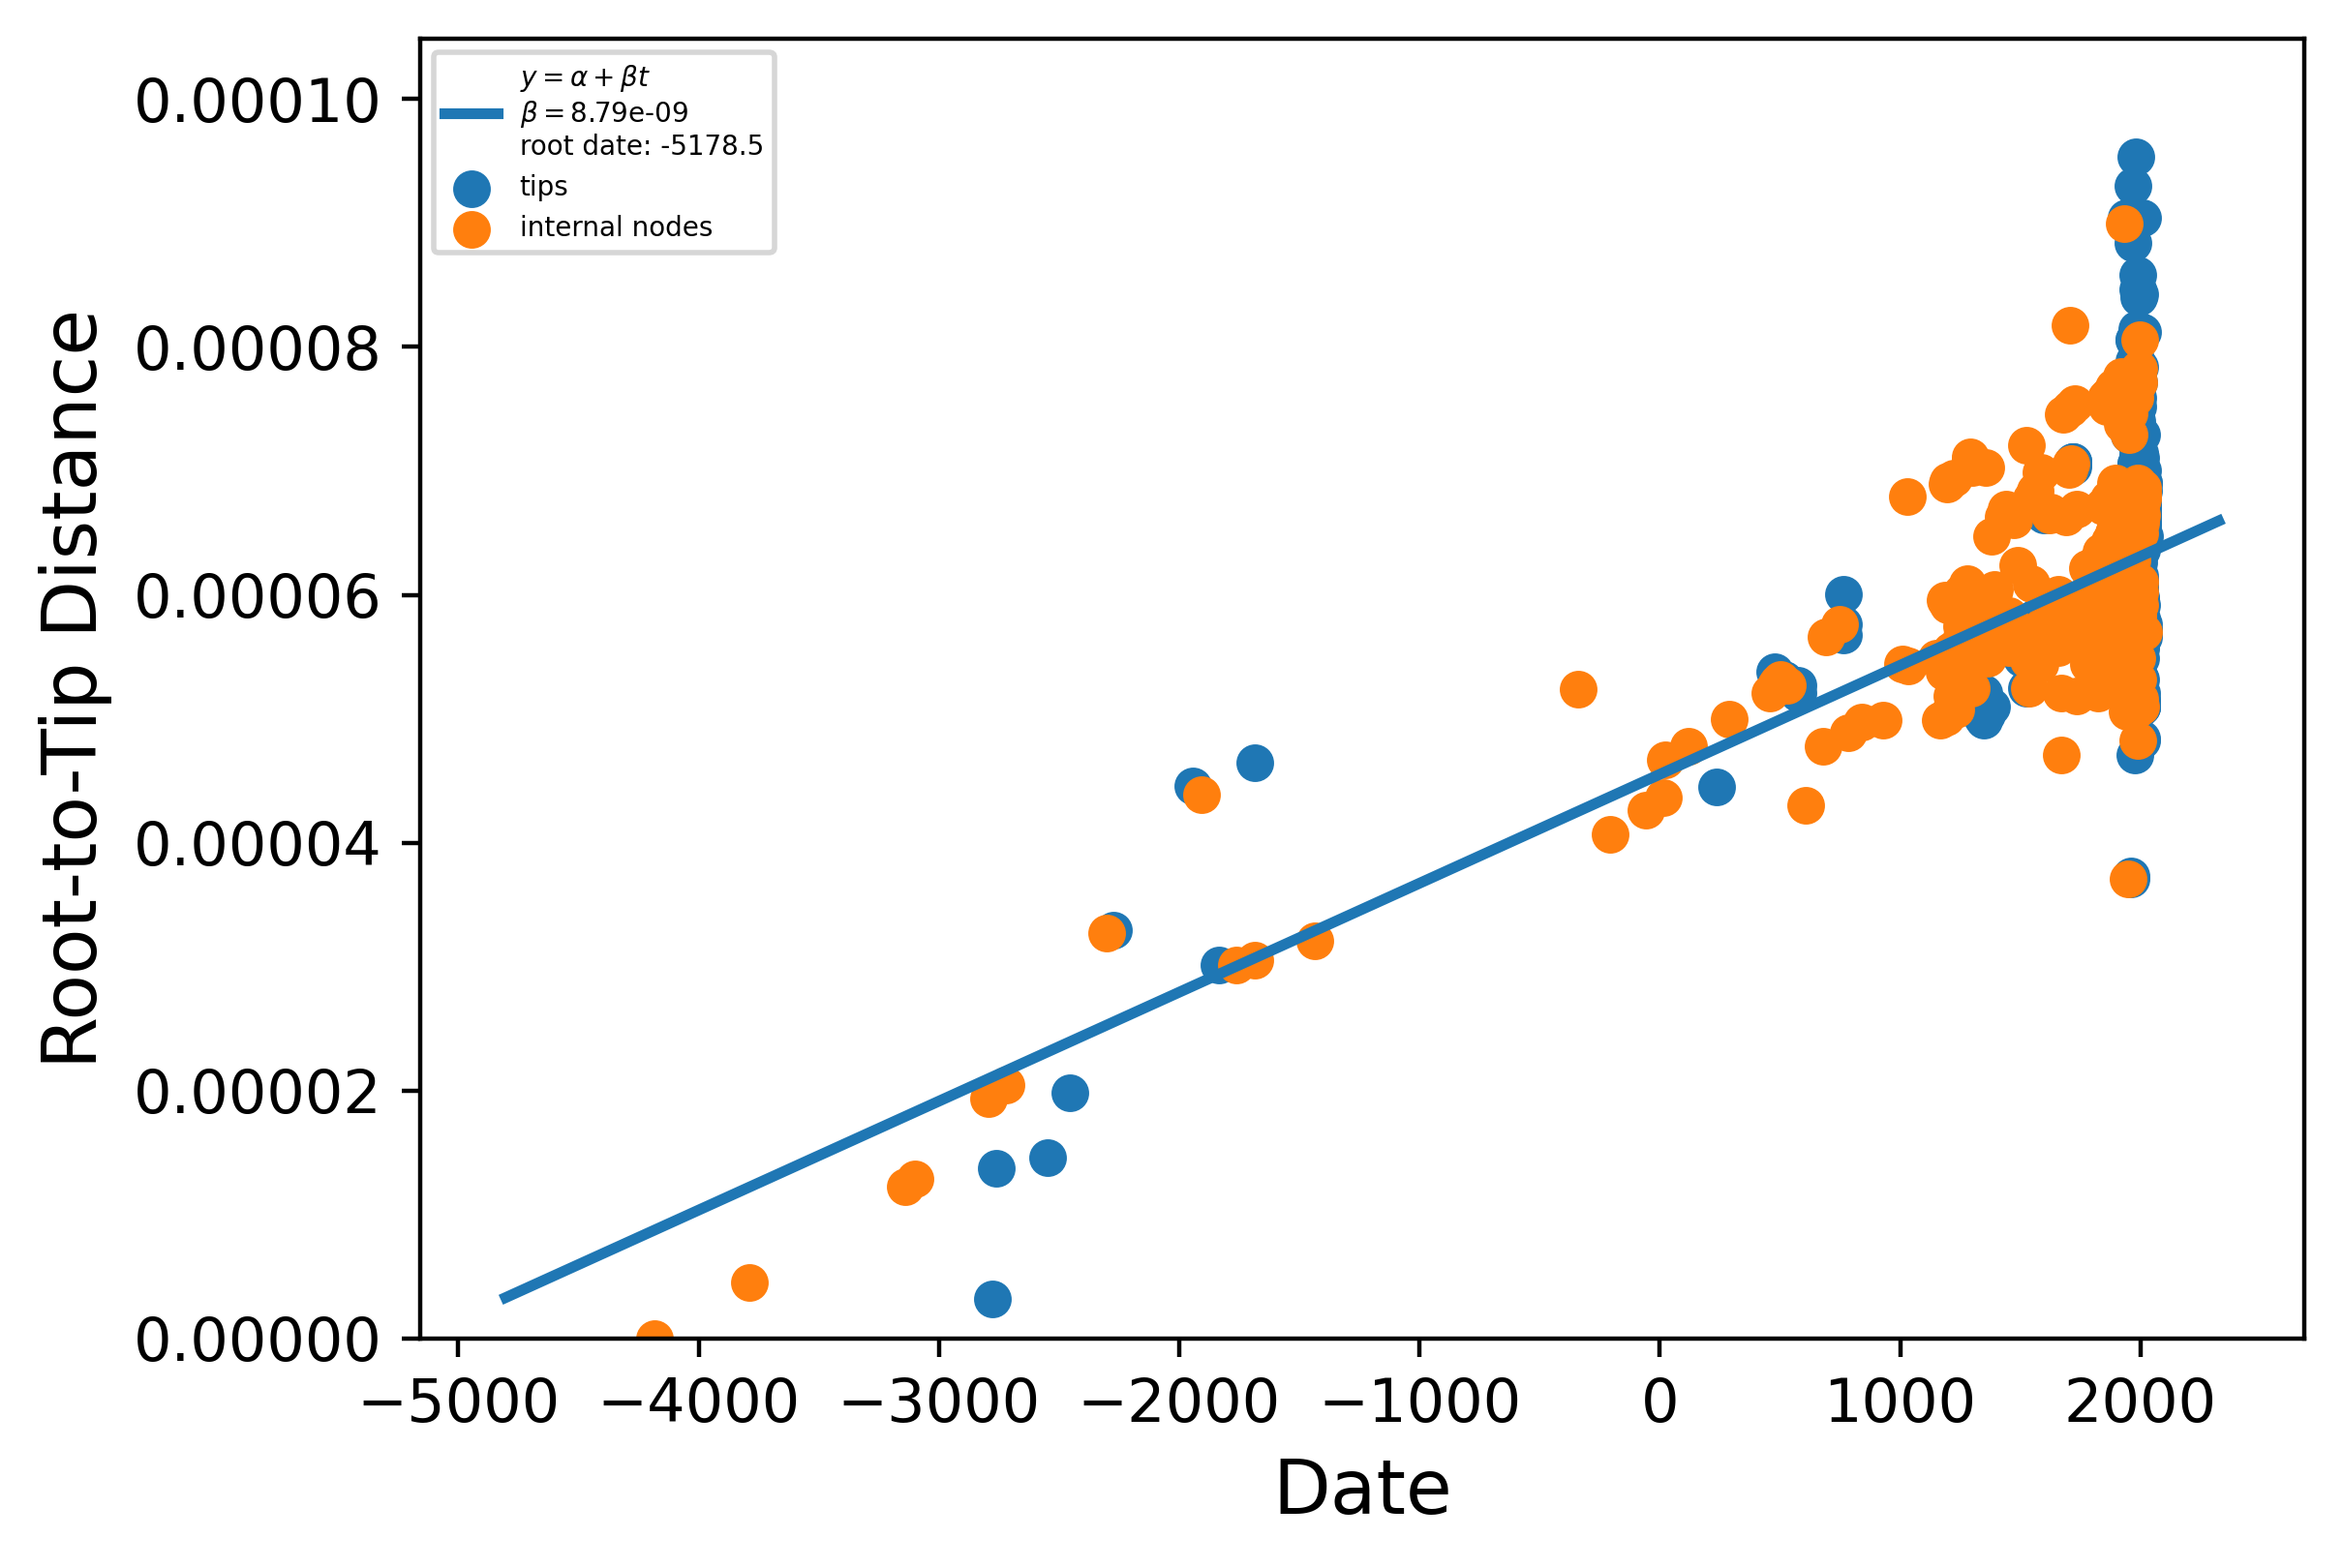

In [6]:
# Root to tip regression
fig, (ax1) = plt.subplots(1, dpi=400)
tt.plot_root_to_tip(
    ax=ax1,
    add_internal=True,
    )
#ax1.get_lines()[0].set_color("#1f77b4")
#ax1.get_lines()[0].set_color("#ff7f0e")
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")
plt.legend(loc=2)

out_path = os.path.join(outdir, "timetree_rtt_post_auto.jpg") 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

### Root-to-tip regression (manual)

I should add this to the dataframe

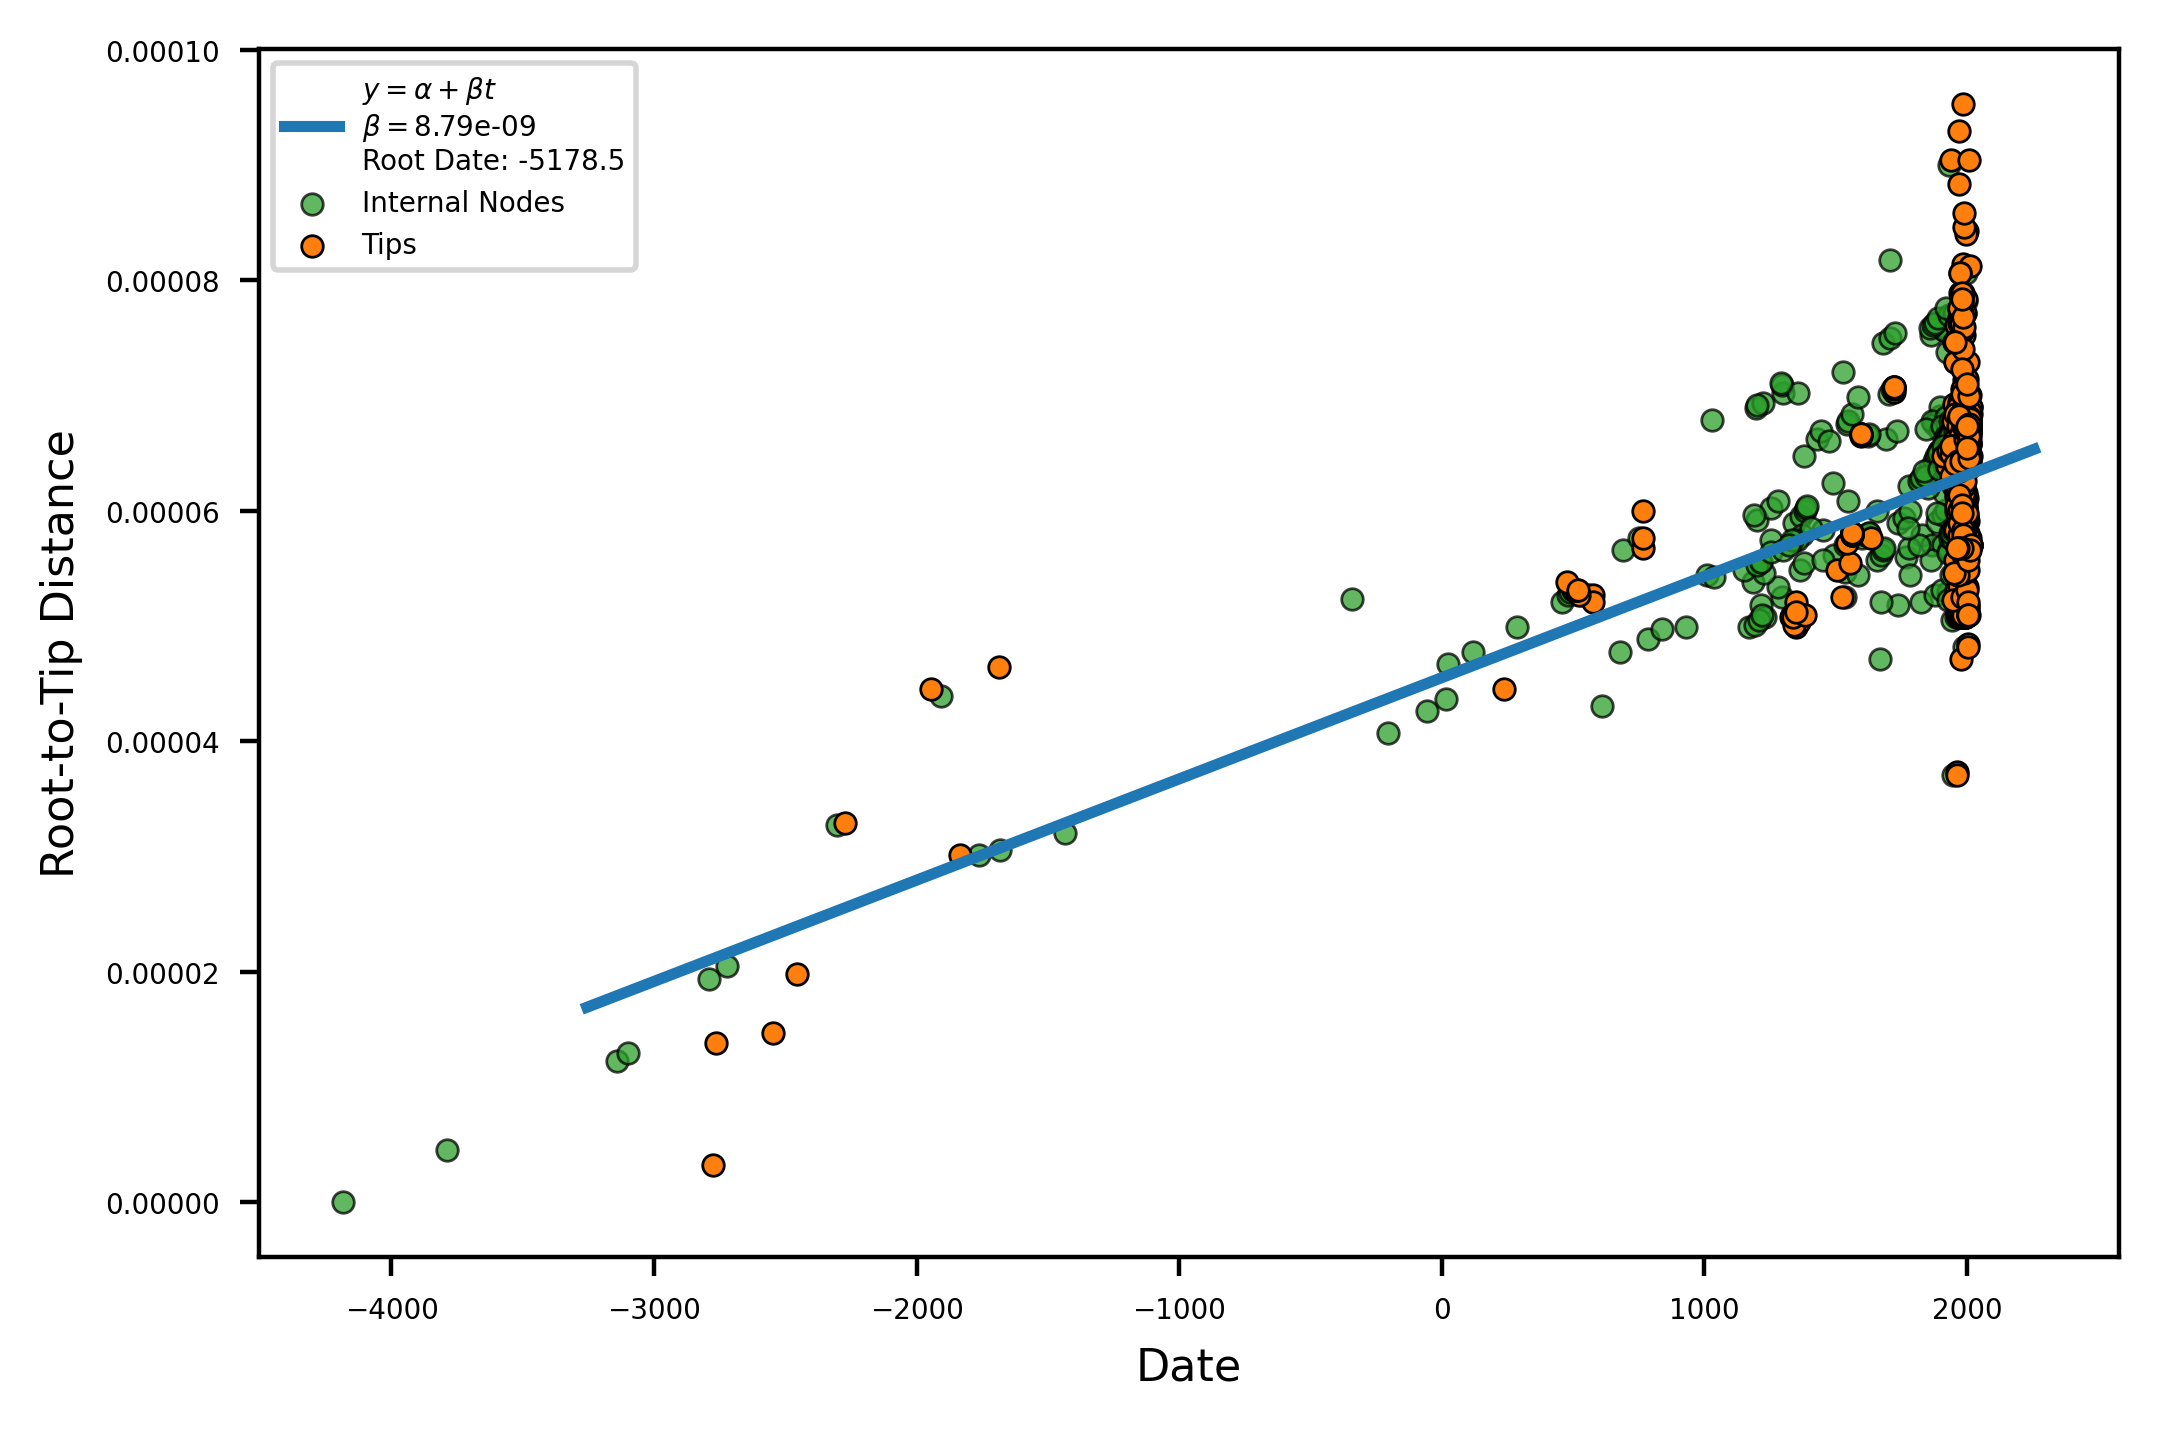

In [7]:
tips = tt.tree.get_terminals()
internal = tt.tree.get_nonterminals()
regression = tt.clock_model

# Set up the tip scatter data
tt_reg = tt.setup_TreeRegression()
xi = np.array([tt_reg.tip_value(n) for n in tips])
yi = np.array([n._v for n in tips])
ind = np.array([n.bad_branch  if hasattr(n, 'bad_branch') else False for n in tips])

# Set up the internal scatter data
xi_int = np.array([n.numdate for n in internal])
yi_int = np.array([n._v for n in internal])
ind_int = np.array([n.bad_branch  if hasattr(n, 'bad_branch') else False  for n in internal])

# When no confidence is enabled
dev_rtt = None
dev_slope = None
        
        
# Set up the regression date
t_mrca = -regression['intercept']/regression['slope']
"""
if add_internal:
    time_span = np.max(xi_int[~ind_int]) - np.min(xi_int[~ind_int])
    x_vals = np.array([max(np.min(xi_int[~ind_int]), t_mrca) - 0.1*time_span, np.max(xi[~ind])+0.05*time_span])
"""
time_span = np.max(xi[~ind]) - np.min(xi[~ind])
x_vals = np.array([max(np.min(xi[~ind]), t_mrca) - 0.1*time_span, np.max(xi[~ind]+0.05*time_span)])
                
# Root to tip regression
fig, (ax1) = plt.subplots(1, dpi=400)

# Internal Scatter
ax1.scatter(xi_int[~ind_int], 
            yi_int[~ind_int], 
            label="Internal Nodes",
            color=cmaplist[2],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,)

# Tips Scatter
ax1.scatter(xi[~ind], 
            yi[~ind], 
            label=("Tips"),
            color=cmaplist[1],
            edgecolor="black",
            linewidth=0.5,
            s=15,
           )


# Regression line
ax1.plot(x_vals, 
         regression['slope']*x_vals + regression['intercept'],
         label = r"$y=\alpha + \beta t$"+"\n"+
                r"$\beta=$%1.2e"%(regression["slope"])
                + ("+/- %1.e"%dev_slope if dev_slope else "") +
                "\nRoot Date: %1.1f"%(-regression['intercept']/regression['slope']) +
                ("+/- %1.2f"%dev_rtt if dev_rtt else ""),
         color=cmaplist[0],
        )

# Labels
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")
plt.legend(loc=2)

out_path = os.path.join(outdir, "timetree_rtt_post_manual.jpg") 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

109.67	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


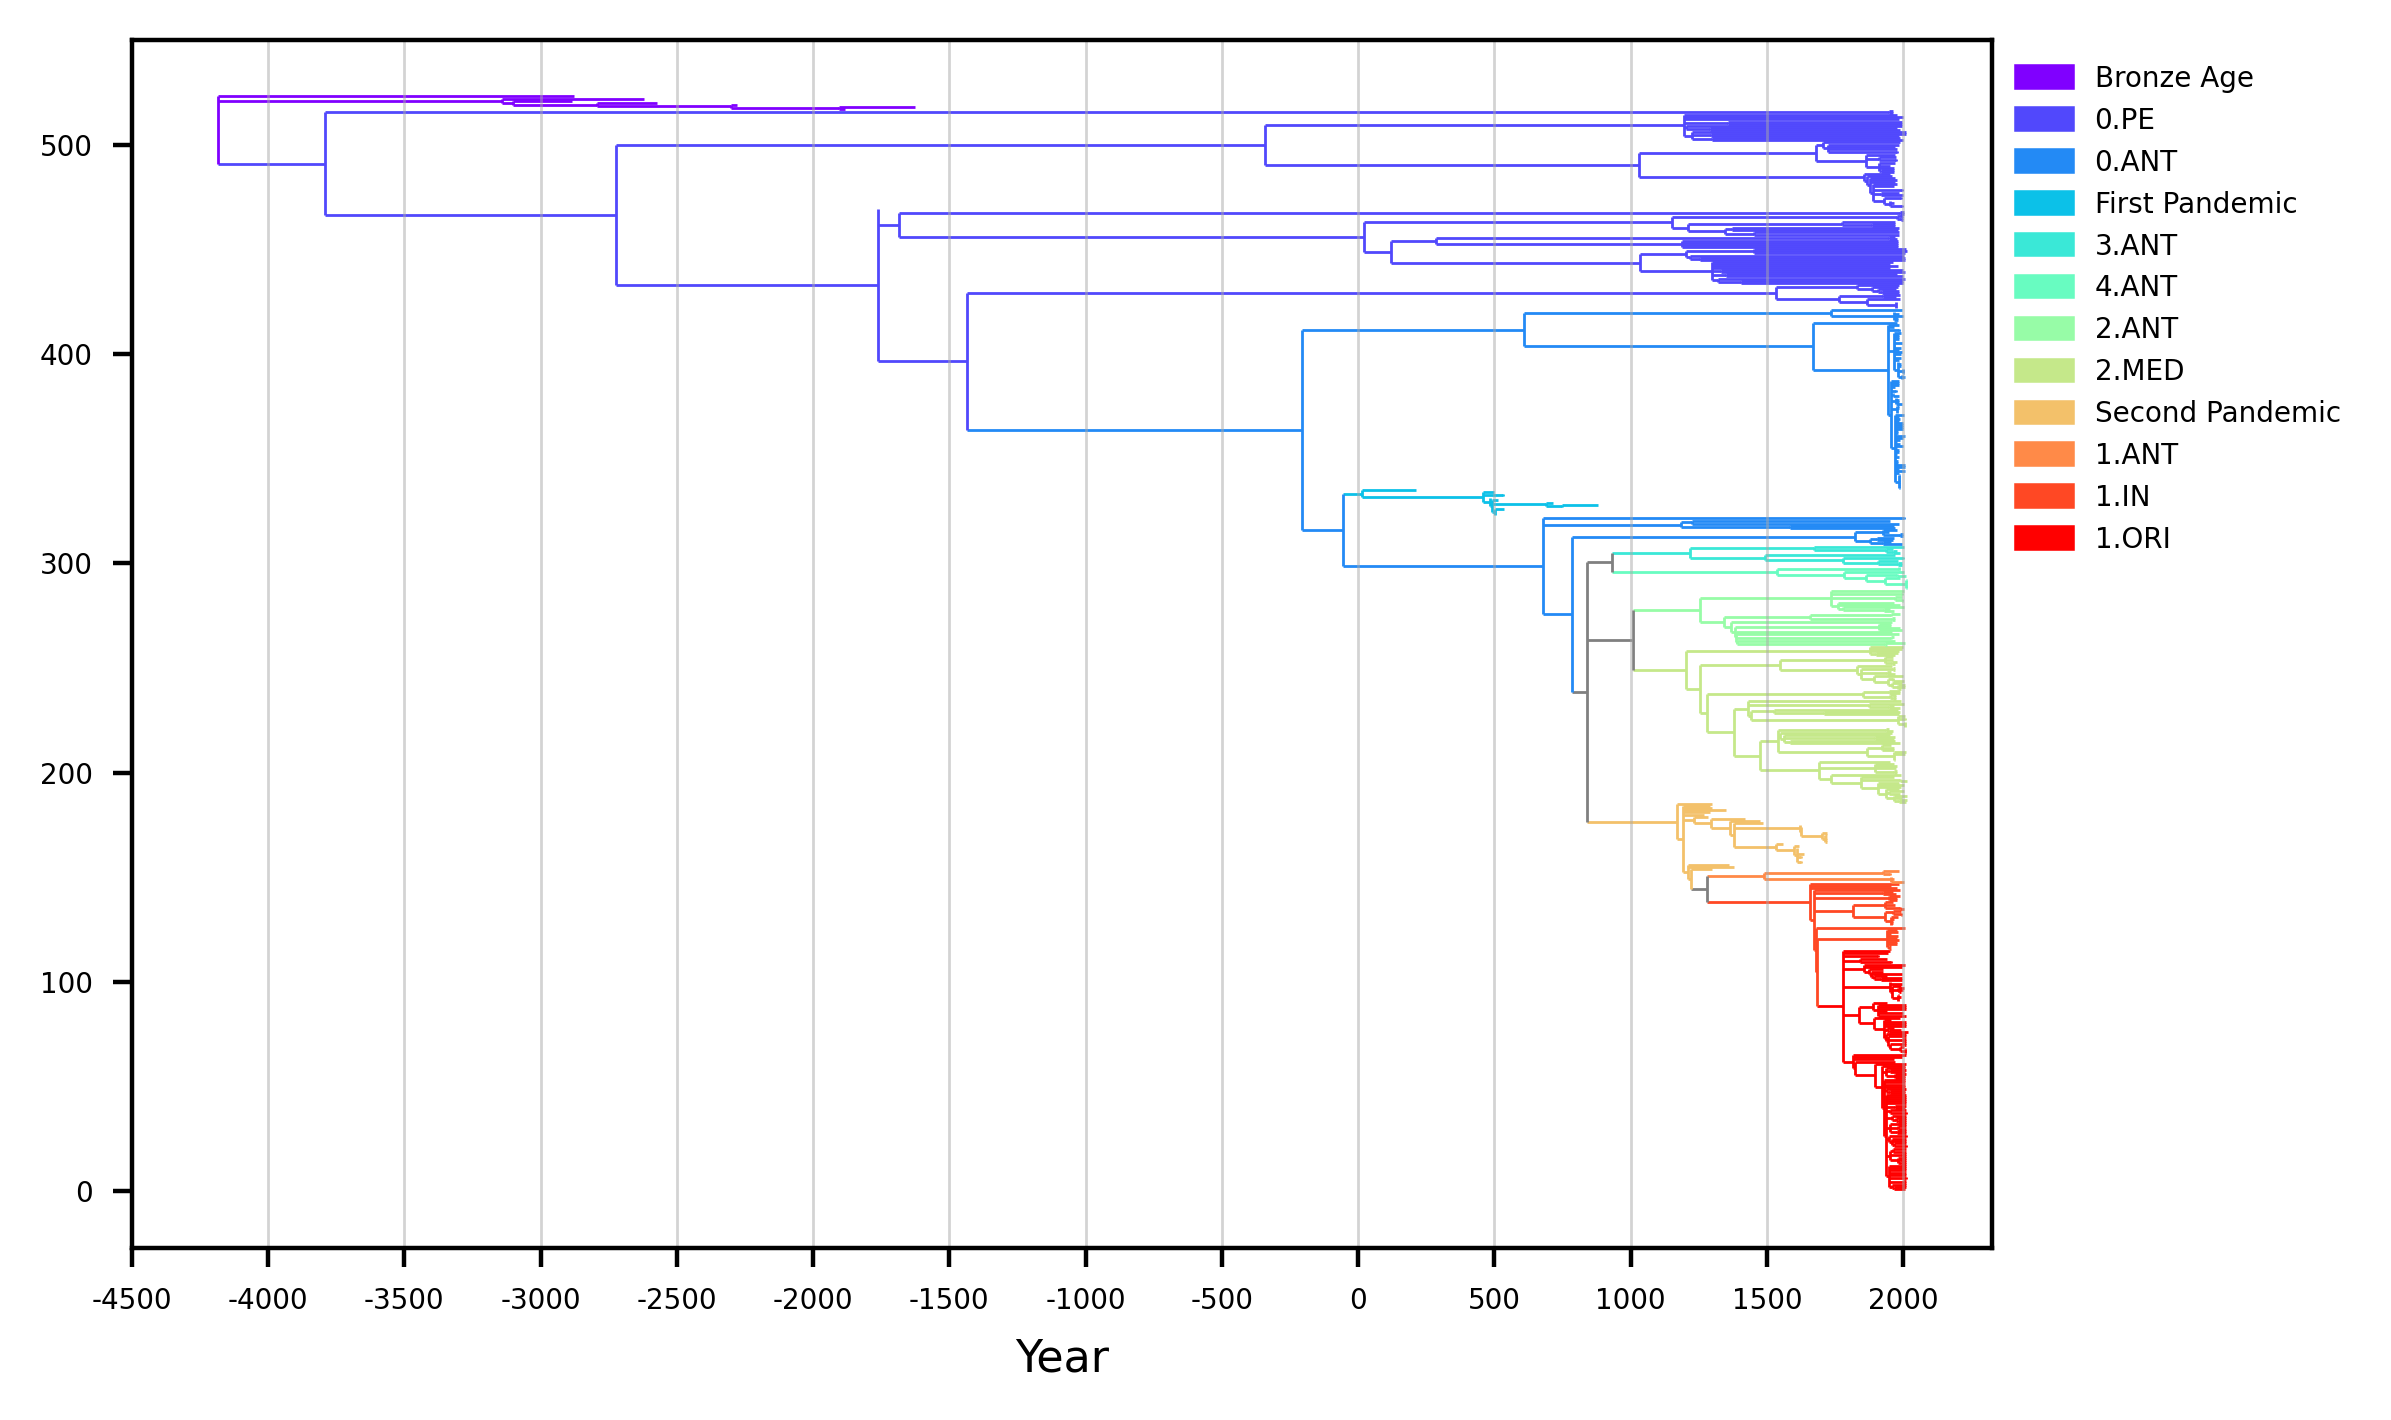

In [8]:
fig = plt.figure(dpi=dpi)
ax1 = plt.subplot()


mug_dict = {MUG_ATTR: {"hex_color": {}}}

# Deepest nodes first 
tt.tree.ladderize(reverse=False)  
# Change the branch color based on a mugration attribute
for c in tt.tree.find_clades():
    mug_val = tree_df["Mugration_" + MUG_ATTR][c.name]
    mug_color = tree_df["Mugration_" + MUG_ATTR + "_Color"][c.name]
    # If it's not an nan
    if not pd.isnull(mug_color):
        c.color = mug_color
    if not pd.isnull(mug_val) and c.is_terminal():
        mug_dict[MUG_ATTR]["hex_color"][mug_val] = mug_color
        

# Convert branch length to years
tt.branch_length_to_years()

# Draw tree to the canvas
# Deepest nodes last?
tt.tree.ladderize(reverse=True)  
plt.rc('lines', linewidth=0.5)
Phylo.draw(tt.tree, 
           axes=ax1, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)


# Labels
ax1.set_xlabel('Year')
ax1.set_ylabel('')
#ax1.set_yticks()

# Step 1: Figure out offset to convert year branch length to calendar date
min_date = tt.tree.root.numdate - tt.tree.root.branch_length
max_date = np.max([n.numdate for n in tt.tree.get_terminals()])
offset = min_date
date_range = np.max([n.numdate for n in tt.tree.get_terminals()]) - min_date

# Step 2: Relabel xticks and space them differently
step = 500

# Distance between ticks
dtick = step
# Minimum tick value
min_tick = step*(offset//step)

# Extra tick increment
extra = dtick if dtick<date_range else dtick
# New tick values
tick_vals = np.arange(min_tick, min_tick+date_range+extra, dtick)
# New tick locations
tick_locs = tick_vals - offset
# New tick labels
tick_labels = ["%d"%(int(x)) for x in tick_vals]

# Set the new tick locations and labels
ax1.set_xticks(tick_locs)
ax1.set_xticklabels(tick_labels)

# Vertical lines for dates
for loc in tick_locs:
    plt.axvline(x=loc, color="darkgrey", alpha=0.5)
#ax1.vlines(tick_locs, ymin=0, ymax=1, color="black")


# Axis Limits
x_buffer = math.ceil((tick_locs[-1] - tick_locs[0]) * 0.05)
y_buffer = math.ceil(len(tt.tree.get_terminals()) * 0.05)

# No x buffer on lower end
ax1.set_xlim(tick_locs[0], tick_locs[-1] + x_buffer)
ax1.set_ylim(0 - y_buffer,len(tt.tree.get_terminals()) + y_buffer)



# Legend
legend_elements = [patches.Patch(facecolor=value, edgecolor=value,) for value in mug_dict[MUG_ATTR]["hex_color"].values()]
legend_labels = list(mug_dict[MUG_ATTR]["hex_color"].keys())

ax1.legend(legend_elements,
           legend_labels,
          bbox_to_anchor=(1.0, 1.0), 
          loc='upper left',
          frameon=False,
         )


# Write to file
out_path = os.path.join(outdir, "timetree_{}.jpg".format(MUG_ATTR.lower()))  
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

### Skyline plot

In [9]:
treetime.wrappers.print_save_plot_skyline(tt, n_std=2.0, screen=True, save=False, plot=True)

AttributeError: 'TreeTime' object has no attribute 'merger_model'